In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import pandas as pd

# Path to the CSV file
file_path = r"C:\Users\radhi\Downloads\archive (1)\credit_card_transactions-ibm_v2.csv"

# Read the entire CSV (if it's not too large for memory)
df = pd.read_csv(file_path)

# Check total counts of fraud and non-fraud
print("Total counts of fraud and non-fraud transactions:")
print(df['Is Fraud?'].value_counts())

# Separate Fraudulent and Non-Fraudulent records
fraud = df[df['Is Fraud?'] == 'Yes']
non_fraud = df[df['Is Fraud?'] == 'No']

print(f"\nTotal Fraud records: {len(fraud)}")
print(f"Total Non-Fraud records: {len(non_fraud)}")


Total counts of fraud and non-fraud transactions:
Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

Total Fraud records: 29757
Total Non-Fraud records: 24357143


--------Data Pre Processing-------

In [ ]:
import pandas as pd

# Path to the CSV file
file_path = r"C:\Users\radhi\Downloads\archive (1)\credit_card_transactions-ibm_v2.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Filter Fraudulent and Non-Fraudulent records
fraud = df[df['Is Fraud?'] == 'Yes']
non_fraud = df[df['Is Fraud?'] == 'No']

# Selecting 100000 records from the dataset
# Determine the required number of records
fraud_count = 10000
non_fraud_count = 100000 - fraud_count  # Remaining

# Sample the required number of records
fraud_sample = fraud.sample(n=fraud_count, random_state=42)
non_fraud_sample = non_fraud.sample(n=non_fraud_count, random_state=42)

# Combine and shuffle the samples
sampled_df = pd.concat([fraud_sample, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the counts
print("Sampled Data Distribution:")
print(sampled_df['Is Fraud?'].value_counts())
print(f"Sampled Data Shape: {sampled_df.shape}")

# Save the sampled data to a new CSV if needed
output_path = r"C:\Users\radhi\Downloads\sampled_credit_card_transactions.csv"
sampled_df.to_csv(output_path, index=False)


Sampled Data Distribution:
Is Fraud?
No     90000
Yes    10000
Name: count, dtype: int64
Sampled Data Shape: (100000, 15)


In [ ]:
df = sampled_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            100000 non-null  int64  
 1   Card            100000 non-null  int64  
 2   Year            100000 non-null  int64  
 3   Month           100000 non-null  int64  
 4   Day             100000 non-null  int64  
 5   Time            100000 non-null  object 
 6   Amount          100000 non-null  object 
 7   Use Chip        100000 non-null  object 
 8   Merchant Name   100000 non-null  int64  
 9   Merchant City   100000 non-null  object 
 10  Merchant State  83768 non-null   object 
 11  Zip             81099 non-null   float64
 12  MCC             100000 non-null  int64  
 13  Errors?         1847 non-null    object 
 14  Is Fraud?       100000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 11.4+ MB


In [ ]:

df [df['Is Fraud?'] == 'Yes'].shape

(10000, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'User'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Year'),
  Text(6, 0, 'Month'),
  Text(7, 0, 'Day'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Amount'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Merchant Name'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'MCC'),
  Text(14, 0, 'Is Fraud?')])

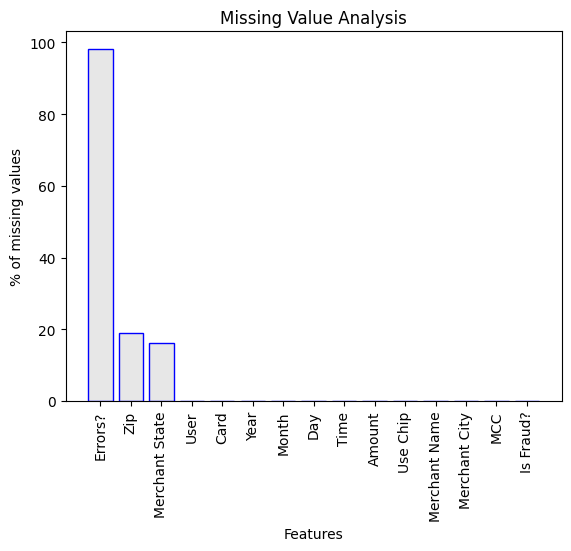

In [ ]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [ ]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [ ]:
df.Amount.head(5)

0     $95.00
1    $100.00
2     $80.00
3      $2.85
4      $8.20
Name: Amount, dtype: object

In [ ]:

df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [ ]:

df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [ ]:
df.Hour

0        13
1        11
2        07
3        05
4        07
         ..
99995    18
99996    11
99997    06
99998    01
99999    11
Name: Hour, Length: 100000, dtype: object

In [ ]:
df.Minute

0        15
1        19
2        11
3        35
4        46
         ..
99995    38
99996    51
99997    13
99998    01
99999    00
Name: Minute, Length: 100000, dtype: object

In [ ]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            100000 non-null  int64  
 1   Month           100000 non-null  int64  
 2   Day             100000 non-null  int64  
 3   Amount          100000 non-null  float64
 4   Use Chip        100000 non-null  object 
 5   Merchant Name   100000 non-null  int64  
 6   Merchant City   100000 non-null  object 
 7   Merchant State  83768 non-null   object 
 8   Zip             81099 non-null   float64
 9   MCC             100000 non-null  int64  
 10  Errors?         1847 non-null    object 
 11  Is Fraud?       100000 non-null  object 
 12  card_id         100000 non-null  object 
 13  Hour            100000 non-null  object 
 14  Minute          100000 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 11.4+ MB


In [ ]:
df["Errors?"].unique()

array([nan, 'Insufficient Balance', 'Bad PIN', 'Technical Glitch',
       'Bad CVV', 'Bad Card Number', 'Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad PIN,Insufficient Balance',
       'Insufficient Balance,Technical Glitch', 'Bad Zipcode',
       'Bad CVV,Insufficient Balance'], dtype=object)

In [ ]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [ ]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [ ]:

df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [ ]:
df["Errors?"].unique()

array([10,  8,  5, 11,  0,  2,  4,  3,  6,  9,  7,  1])

-----------GNN---------------

In [ ]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')

In [ ]:
# Add edges and properties to the edges
for _, row in df.iterrows():
    # Create a variable for each properties for each edge

        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']


        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)



In [ ]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 16521
Number of edges: 100000


In [ ]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [ ]:
adj_matrix.shape

(16521, 16521)

In [ ]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 697_1, Properties: card_id
Node: 226_2, Properties: card_id
Node: 1662_1, Properties: card_id
Node: 1997_0, Properties: card_id
Node: 1255_0, Properties: card_id
Node: 396_1, Properties: card_id
Node: 393_1, Properties: card_id
Node: 790_1, Properties: card_id
Node: 271_2, Properties: card_id
Node: 1889_1, Properties: card_id


In [ ]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2015,), 'month': (1,), 'day': (9,), 'hour': ('13',), 'minute': ('15',), 'amount': (95.0,), 'use_chip': (0,), 'merchant_city': (2632,), 'errors': (10,), 'mcc': 5541}, 1: {'year': (2018,), 'month': (1,), 'day': (12,), 'hour': ('16',), 'minute': ('57',), 'amount': (103.24,), 'use_chip': (0,), 'merchant_city': (2632,), 'errors': (10,), 'mcc': 5541}}
{0: {'year': (2015,), 'month': (1,), 'day': (9,), 'hour': ('13',), 'minute': ('15',), 'amount': (95.0,), 'use_chip': (0,), 'merchant_city': (2632,), 'errors': (10,), 'mcc': 5541}, 1: {'year': (2018,), 'month': (1,), 'day': (12,), 'hour': ('16',), 'minute': ('57',), 'amount': (103.24,), 'use_chip': (0,), 'merchant_city': (2632,), 'errors': (10,), 'mcc': 5541}}
{0: {'year': (2014,), 'month': (12,), 'day': (20,), 'hour': ('11',), 'minute': ('32',), 'amount': (21.72,), 'use_chip': (2,), 'merchant_city': (2817,), 'errors': (10,), 'mcc': 5311}}
{0: {'year': (2006,), 'month': (9,), 'day': (19,), 'hour': ('07',), 'minute': ('21',), 'amoun

In [ ]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")

Property value: (10,), Count: 98153
Property value: (8,), Count: 1042
Property value: (4,), Count: 82
Property value: (0,), Count: 126
Property value: (11,), Count: 213
Property value: (5,), Count: 282
Property value: (2,), Count: 88
Property value: (6,), Count: 3
Property value: (7,), Count: 5
Property value: (9,), Count: 3
Property value: (1,), Count: 2
Property value: (3,), Count: 1


In [ ]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [ ]:
list(edge_list[i][2].values())

[(2006,), (9,), (6,), ('16',), ('32',), (102.07,), (2,), (2632,), (10,), 5411]

In [ ]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [ ]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid =  train_test_split(x, target, test_size=0.2, stratify=target)
x_valid, x_test, y_valid, y_test =  train_test_split(x_valid, y_valid, test_size=0.5, stratify=y_valid)

In [ ]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=1000

# Define the loss function and optimizer
pos_weight = torch.tensor([len(df[df['Is Fraud?'] == 0]) / len(df[df['Is Fraud?'] == 1]) ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 314.7911682128906
Epoch: 20, Loss: 35.44382858276367
Epoch: 40, Loss: 11.359902381896973
Epoch: 60, Loss: 4.441132068634033
Epoch: 80, Loss: 1.914249062538147
Epoch: 100, Loss: 2.5003931522369385
Epoch: 120, Loss: 7.682397365570068
Epoch: 140, Loss: 5.1276397705078125
Epoch: 160, Loss: 2.541593551635742
Epoch: 180, Loss: 6.111086368560791
Epoch: 200, Loss: 3.9240593910217285
Epoch: 220, Loss: 2.3220157623291016
Epoch: 240, Loss: 5.169547080993652
Epoch: 260, Loss: 3.5848677158355713
Epoch: 280, Loss: 1.9791350364685059
Epoch: 300, Loss: 4.233722686767578
Epoch: 320, Loss: 3.284396171569824
Epoch: 340, Loss: 1.3745535612106323
Epoch: 360, Loss: 1.2889937162399292
Epoch: 380, Loss: 1.2715200185775757
Epoch: 400, Loss: 1.2619109153747559
Epoch: 420, Loss: 1.2591643333435059
Epoch: 440, Loss: 1.2574940919876099
Epoch: 460, Loss: 1.2562283277511597
Epoch: 480, Loss: 1.255220890045166
Epoch: 500, Loss: 1.2543889284133911
Epoch: 520, Loss: 1.2536958456039429
Epoch: 540, Loss: 

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    test_output = model(x_test)
    test_predictions = torch.sigmoid(test_output)
    predicted_labels = (test_predictions > 0.7).float()

# Calculate accuracy on the test set
test_accuracy = torch.mean((predicted_labels == y_test).float())
print(f'Test Accuracy: {test_accuracy.item()}')

Test Accuracy: 0.7687000036239624


In [ ]:
# Filter for fraud cases in the test set
fraud_indices = (y_test == 1).nonzero(as_tuple=True)[0]
fraud_predictions = predicted_labels[fraud_indices]
fraud_actual = y_test[fraud_indices]

# Print the actual and predicted values for fraud cases
for i in range(len(fraud_actual)):
    print(f"Actual: {fraud_actual[i].item()}, Predicted: {fraud_predictions[i].item()}")

# Calculate how many fraud cases were predicted correctly
correct_fraud_predictions = (fraud_predictions == fraud_actual).sum().item()
total_fraud_cases = len(fraud_actual)

print(f"Correct fraud predictions: {correct_fraud_predictions}/{total_fraud_cases}")


Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predict

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert tensors to numpy arrays for Scikit-Learn compatibility
y_test_np = y_test.cpu().numpy()  # Convert test labels to numpy array
predicted_labels_np = predicted_labels.cpu().numpy()  # Convert predictions to numpy array

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_np, predicted_labels_np)
recall = recall_score(y_test_np, predicted_labels_np)
f1 = f1_score(y_test_np, predicted_labels_np)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.1071
Recall: 0.1790
F1 Score: 0.1340


--------GAT------------

In [ ]:
! pip install torch-geometric


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch_geometric.utils import from_networkx
import networkx as nx

In [ ]:
data = from_networkx(G)

In [ ]:
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df['Minute'] = pd.to_numeric(df['Minute'], errors='coerce')

In [ ]:
# Assuming 'card_id' and 'Merchant Name' are strings, we need to encode them
card_to_idx = {card: idx for idx, card in enumerate(df['card_id'].unique())}
merchant_to_idx = {merchant: idx for idx, merchant in enumerate(df['Merchant Name'].unique())}

# Convert 'card_id' and 'Merchant Name' to numerical IDs
df['card_id_idx'] = df['card_id'].map(card_to_idx)
df['merchant_id_idx'] = df['Merchant Name'].map(merchant_to_idx)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Year             100000 non-null  int64  
 1   Month            100000 non-null  int64  
 2   Day              100000 non-null  int64  
 3   Amount           100000 non-null  float64
 4   Use Chip         100000 non-null  int32  
 5   Merchant Name    100000 non-null  int64  
 6   Merchant City    100000 non-null  int32  
 7   MCC              100000 non-null  int64  
 8   Errors?          100000 non-null  int32  
 9   Is Fraud?        100000 non-null  int64  
 10  card_id          100000 non-null  object 
 11  Hour             100000 non-null  int64  
 12  Minute           100000 non-null  int64  
 13  card_id_idx      100000 non-null  int64  
 14  merchant_id_idx  100000 non-null  int64  
dtypes: float64(1), int32(3), int64(10), object(1)
memory usage: 10.3+ MB


In [ ]:
edge_features = []
edges = []

for _, row in df.iterrows():
    edge_feature = [
        row["Year"], row["Month"], row["Day"], row["Hour"], row["Minute"],
        row["Amount"], row["Use Chip"], row["Merchant City"], row["Errors?"], row["MCC"]
    ]
    edge_features.append(edge_feature)  # Ensure each item is a list of values
    edges.append((row['card_id_idx'], row['merchant_id_idx']))
# Debug: Print a sample of edge_features to confirm structure
print(edge_features[:5])  # This should now show a list of lists with integers and floats




[[2015, 1, 9, 13, 15, 95.0, 0, 2632, 10, 5541], [2019, 12, 4, 11, 19, 100.0, 0, 5008, 10, 4829], [2012, 11, 22, 7, 11, 80.0, 2, 5123, 10, 5541], [2017, 6, 23, 5, 35, 2.85, 0, 1368, 10, 5411], [2019, 8, 29, 7, 46, 8.2, 0, 4407, 10, 5812]]


In [ ]:
# Convert edge features to a tensor
edge_attr_tensor = torch.tensor(edge_features, dtype=torch.float)



In [ ]:
edge_attr_tensor[:, 8] = edge_attr_tensor[:, 8] * 5

In [ ]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [ ]:
data = Data(edge_index=edge_index, edge_attr=edge_attr_tensor)
print(data)

Data(edge_index=[2, 100000], edge_attr=[100000, 10])


In [ ]:
num_nodes = data.num_nodes  # Replace with your graph's number of nodes
node_features = torch.ones((num_nodes, 10))

c:\Users\radhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'edge_attr'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm

class EdgeGAT(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super(EdgeGAT, self).__init__()

        self.dropout = dropout

        # First GATConv layer
        self.conv1 = GATConv(in_channels, out_channels, heads=2, concat=True, dropout=0.1, edge_dim=in_channels)
        self.bn1 = BatchNorm(out_channels * 2)  # Adjusted for concatenation

        # Intermediate GATConv layer
        self.conv3 = GATConv(out_channels * 2, out_channels, heads=2, concat=True, dropout=0.1, edge_dim=in_channels)
        self.bn2 = BatchNorm(out_channels * 2)

        # Final GATConv layer for edge-level classification
        self.conv2 = GATConv(out_channels * 2, 1, heads=1, concat=False, dropout=0.1, edge_dim=in_channels)

    def forward(self, x, edge_index, edge_attr):
        # Apply the first GATConv layer
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.bn1(x)  # Apply BatchNorm
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Apply the intermediate GATConv layer
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.bn2(x)  # Apply BatchNorm
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Apply the final GATConv layer for classification
        x = self.conv2(x, edge_index, edge_attr)

        # Aggregate node features for each edge (source + target nodes)
        source, target = edge_index  # Split edge_index into source and target nodes
        edge_features = (x[source] + x[target]) / 2  # Example: mean of source and target features

        return edge_features.squeeze()

In [ ]:
# Example data
num_nodes = 11521
num_edges = 80000
in_channels = 10  # Feature dimension
out_channels = 32  # Hidden dimension

node_features = torch.rand((num_nodes, in_channels))
edge_index = torch.randint(0, num_nodes, (2, num_edges))  # Random edge index
edge_attr = torch.rand((num_edges, in_channels))  # Edge attributes

# Labels for edge-level classification
train_y = torch.tensor(df['Is Fraud?'].values).float()

# Initialize model
model = EdgeGAT(in_channels=in_channels, out_channels=out_channels)

# Forward pass
out = model(node_features, edge_index, edge_attr)

print(f"Output size: {out.size()}")

Output size: torch.Size([80000])


In [ ]:

# Define the loss function and optimizer
pos_weight = torch.tensor([len(df[df['Is Fraud?'] == 0]) / len(df[df['Is Fraud?'] == 1]) ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Split data (ensure correct data handling)
train_edge_index, test_edge_index, train_edge_attr, test_edge_attr = train_test_split(
    data.edge_index.t().numpy(), data.edge_attr.numpy(), test_size=0.2, random_state=42
)

# Convert to tensors
train_edge_index = torch.tensor(train_edge_index.T, dtype=torch.long)
test_edge_index = torch.tensor(test_edge_index.T, dtype=torch.long)
train_edge_attr = torch.tensor(train_edge_attr, dtype=torch.float)
test_edge_attr = torch.tensor(test_edge_attr, dtype=torch.float)

print(f"Node Features size: {node_features.size()}")  # Should be [num_nodes, feature_dim]

Node Features size: torch.Size([11521, 10])


In [ ]:
# Map 'y' to edge-level targets based on the DataFrame
train_indices = train_edge_index.t().numpy()
test_indices = test_edge_index.t().numpy()

# Create train_y and test_y by mapping edges to corresponding 'Is Fraud?' values
train_y = []
for edge in train_indices:
    src, tgt = edge
    label = df[(df['card_id_idx'] == src) & (df['merchant_id_idx'] == tgt)]['Is Fraud?'].values
    train_y.append(label[0] if len(label) > 0 else 0)  # Default to 0 if no match

test_y = []
for edge in test_indices:
    src, tgt = edge
    label = df[(df['card_id_idx'] == src) & (df['merchant_id_idx'] == tgt)]['Is Fraud?'].values
    test_y.append(label[0] if len(label) > 0 else 0)  # Default to 0 if no match

# Convert to tensors
train_y = torch.tensor(train_y, dtype=torch.float)
test_y = torch.tensor(test_y, dtype=torch.float)

# Debugging: Check sizes
print(f"Train Y size: {train_y.size()}, Test Y size: {test_y.size()}")

# Check train_edge_index dimensions
print(f"Train Edge Index size: {train_edge_index.size()}")  # Should be [2, num_edges]

# Verify the number of edges matches train_y size
assert train_edge_index.size(1) == train_y.size(0), "Mismatch between train_edge_index and train_y sizes!"
assert test_edge_index.size(1) == test_y.size(0), "Mismatch between test_edge_index and test_y sizes!"

print(f"Output size: {out.squeeze().size()}, Target size: {train_y.size()}")

Train Y size: torch.Size([80000]), Test Y size: torch.Size([20000])
Train Edge Index size: torch.Size([2, 80000])
Output size: torch.Size([80000]), Target size: torch.Size([80000])


In [ ]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(node_features, train_edge_index, train_edge_attr).squeeze()  # Squeeze to match target dimensions

    # Compute the loss
    loss = criterion(out, train_y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Debugging: Ensure output and target shapes align
print(f"Output size: {out.size()}, Train Y size: {train_y.size()}")

Epoch 0, Loss: 1.4837028980255127
Epoch 50, Loss: 1.15700101852417
Epoch 100, Loss: 1.1367149353027344
Epoch 150, Loss: 1.133524775505066
Epoch 200, Loss: 1.0798358917236328
Epoch 250, Loss: 1.0709763765335083
Epoch 300, Loss: 1.0905072689056396
Epoch 350, Loss: 1.0714013576507568
Epoch 400, Loss: 1.0979256629943848
Epoch 450, Loss: 1.0451369285583496
Output size: torch.Size([80000]), Train Y size: torch.Size([80000])


In [ ]:
# Evaluation phase
model.eval()
with torch.no_grad():
    out_test = model(node_features, test_edge_index, test_edge_attr).squeeze()

    # Debugging test output
    print(f"Test Output size: {out_test.size()}, Test Y size: {test_y.size()}")

    # Ensure sizes match
    assert out_test.size(0) == test_y.size(0), "Mismatch between test output and test_y sizes!"

    # Binary classification threshold
    threshold = 0.1
    predicted_labels = (out_test > threshold).float()

    # Evaluate metrics
    precision = precision_score(test_y.numpy(), predicted_labels.numpy())
    recall = recall_score(test_y.numpy(), predicted_labels.numpy())
    f1 = f1_score(test_y.numpy(), predicted_labels.numpy())

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Filter for fraud cases in the test set
fraud_indices = (y_test == 1).nonzero(as_tuple=True)[0]
fraud_predictions = predicted_labels[fraud_indices]
fraud_actual = y_test[fraud_indices]

# Print the actual and predicted values for fraud cases
for i in range(len(fraud_actual)):
    print(f"Actual: {fraud_actual[i].item()}, Predicted: {fraud_predictions[i].item()}")

# Calculate how many fraud cases were predicted correctly
correct_fraud_predictions = (fraud_predictions == fraud_actual).sum().item()
total_fraud_cases = len(fraud_actual)

print(f"Correct fraud predictions: {correct_fraud_predictions}/{total_fraud_cases}")

Test Output size: torch.Size([20000]), Test Y size: torch.Size([20000])
Precision: 0.0993
Recall: 0.4637
F1 Score: 0.1636
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 1.0
Actual: 1.0, Predicted: 0.0
Actual: 1.0, Predicted: 1.0
Actual: 1.

----GraphSAGE---------

In [ ]:
!pip install torch_geometric


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import necessary SMOTE module

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import pandas as pd

# Convert the networkx graph (G) to PyG Data format
graph_data = from_networkx(G)

In [ ]:
card_to_idx = {card: idx for idx, card in enumerate(df['card_id'].unique())}
merchant_to_idx = {merchant: idx for idx, merchant in enumerate(df['Merchant Name'].unique())}

df['card_id_idx'] = df['card_id'].map(card_to_idx)
df['merchant_id_idx'] = df['Merchant Name'].map(merchant_to_idx)

In [ ]:
# Generate edge features and edges
edge_features = []
edges = []

for _, row in df.iterrows():
    edge_feature = [
        row["Year"], row["Month"], row["Day"], row["Hour"], row["Minute"],
        row["Amount"], row["Use Chip"], row["Merchant City"], row["Errors?"], row["MCC"]
    ]
    edge_features.append(edge_feature)
    edges.append((row['card_id_idx'], row['merchant_id_idx']))

In [ ]:
# Convert edge features to a tensor
edge_attr_tensor = torch.tensor(edge_features, dtype=torch.float)

# Convert edges to a tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


In [ ]:
# Prepare node features
num_nodes = len(df['card_id'].unique()) + len(df['Merchant Name'].unique())  # Number of unique nodes
node_features = torch.ones((num_nodes, 10))  # Assuming 10 features for each node (can be adjusted)


In [ ]:
# Define target labels (fraud detection) - Shape should correspond to number of edges
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)


In [ ]:
print("Node features tensor shape:", node_features.shape)

Node features tensor shape: torch.Size([16521, 10])


In [ ]:
card_ids = df['card_id'].unique()
merchants = df['Merchant Name'].unique()

# Create a mapping from card_id and Merchant Name to node index
card_id_to_node = {card: idx for idx, card in enumerate(card_ids)}
merchant_to_node = {merchant: idx + len(card_ids) for idx, merchant in enumerate(merchants)}

# Assign random node features (or domain-specific features) for each unique node
for card in card_ids:
    idx = card_id_to_node[card]
    node_features[idx] = torch.rand(10)  # Random features for the card (replace with actual features)

for merchant in merchants:
    idx = merchant_to_node[merchant]
    node_features[idx] = torch.rand(10)  # Random features for the merchant (replace with actual features)

print("Updated node features:", node_features)


Updated node features: tensor([[0.8613, 0.6878, 0.1904,  ..., 0.7604, 0.3870, 0.5856],
        [0.7433, 0.9734, 0.0075,  ..., 0.3014, 0.1968, 0.4411],
        [0.2879, 0.6406, 0.6766,  ..., 0.3613, 0.0632, 0.8848],
        ...,
        [0.7644, 0.3546, 0.7272,  ..., 0.8397, 0.7537, 0.0994],
        [0.8624, 0.8446, 0.9388,  ..., 0.9212, 0.4096, 0.5308],
        [0.5941, 0.2412, 0.8736,  ..., 0.5506, 0.1766, 0.8093]])


In [ ]:
# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr_tensor, y=target)

In [ ]:
edge_index_train, edge_index_test, y_train, y_test = train_test_split(
    data.edge_index.t().numpy(), data.y.numpy(), test_size=0.2, random_state=42
)

# Convert back to PyTorch tensors
edge_index_train = torch.tensor(edge_index_train.T, dtype=torch.long)
edge_index_test = torch.tensor(edge_index_test.T, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# Split edge features into train and test
edge_attr_train, edge_attr_test = train_test_split(
    data.edge_attr.numpy(), test_size=0.2, random_state=42
)

# Convert back to PyTorch tensors
edge_attr_train = torch.tensor(edge_attr_train, dtype=torch.float)
edge_attr_test = torch.tensor(edge_attr_test, dtype=torch.float)

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)

        # Apply an edge-based readout (combine node features at edge level)
        edge_embeddings = x[edge_index[0]] * x[edge_index[1]]  # Combine features from both nodes at each edge
        return edge_embeddings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Calculate the class weights for BCEWithLogitsLoss
num_non_fraud = len(df[df['Is Fraud?'] == 0])
num_fraud = len(df[df['Is Fraud?'] == 1])
pos_weight = torch.tensor([num_non_fraud  / num_fraud * 0.8])  # Class imbalance adjustment

# Define the model (GraphSAGE for example)
model = GraphSAGE(in_channels=10, hidden_channels=128, out_channels=1)  # Output 1 for binary classification

# Define the loss function with pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Now, you can proceed with your training loop


In [ ]:
# Training loop
def train(model, data, edge_index_train, edge_attr_train, y_train):
    model.train()
    optimizer.zero_grad()

    # Create a new data object for the training set
    data_train = Data(x=data.x, edge_index=edge_index_train, edge_attr=edge_attr_train, y=y_train)

    # Get the edge-level predictions
    out = model(data_train)

    # Flatten the output to match the target shape (i.e., [batch_size] instead of [batch_size, 1])
    out = out.view(-1)  # Flatten output

    # Binary cross-entropy loss for edge-level prediction
    loss = F.binary_cross_entropy_with_logits(out, y_train)
    loss.backward()
    optimizer.step()

    return loss.item(), out  # Return both loss and output

In [ ]:
# Testing loop
def test(model, data, edge_index_test, edge_attr_test, y_test):
    model.eval()

    # Create a new data object for the test set
    data_test = Data(x=data.x, edge_index=edge_index_test, edge_attr=edge_attr_test, y=y_test)

    # Get the edge-level predictions
    out = model(data_test)

    # Flatten the output to match the target shape (i.e., [batch_size] instead of [batch_size, 1])
    out = out.view(-1)  # Flatten output

    # Binary cross-entropy loss for edge-level prediction
    loss = F.binary_cross_entropy_with_logits(out, y_test)

    # Apply sigmoid to get probabilities
    out = torch.sigmoid(out)

    # Binarize the predictions
    y_pred = (out > 0.4).float()

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(y_test.cpu(), y_pred.cpu())
    recall = recall_score(y_test.cpu(), y_pred.cpu())
    f1 = f1_score(y_test.cpu(), y_pred.cpu())

    return loss.item(), precision, recall, f1

In [ ]:
# Training loop
for epoch in range(500):
    train_loss, _ = train(model, data, edge_index_train, edge_attr_train, y_train)
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, Training Loss: {train_loss}')

# After training, compute test metrics (Precision, Recall, F1)
test_loss, precision, recall, f1 = test(model, data, edge_index_test, edge_attr_test, y_test)

# Print test metrics
print(f'Test Loss: {test_loss}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

Epoch 0, Training Loss: 0.7160100340843201
Epoch 20, Training Loss: 0.6933155059814453
Epoch 40, Training Loss: 0.6933906078338623
Epoch 60, Training Loss: 0.69254469871521
Epoch 80, Training Loss: 0.6919896602630615
Epoch 100, Training Loss: 0.6904177665710449
Epoch 120, Training Loss: 0.68715500831604
Epoch 140, Training Loss: 0.6818499565124512
Epoch 160, Training Loss: 0.6779442429542542
Epoch 180, Training Loss: 0.6755403280258179
Epoch 200, Training Loss: 0.6740038394927979
Epoch 220, Training Loss: 0.6736592650413513
Epoch 240, Training Loss: 0.6729025840759277
Epoch 260, Training Loss: 0.6717182397842407
Epoch 280, Training Loss: 0.6711723208427429
Epoch 300, Training Loss: 0.6701749563217163
Epoch 320, Training Loss: 0.6700023412704468
Epoch 340, Training Loss: 0.6695899963378906
Epoch 360, Training Loss: 0.6678500771522522
Epoch 380, Training Loss: 0.6679631471633911
Epoch 400, Training Loss: 0.6678508520126343
Epoch 420, Training Loss: 0.6670271158218384
Epoch 440, Training 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def test_and_verify(model, data, edge_index_test, edge_attr_test, y_test):
    model.eval()

    # Create a new data object for the test set
    data_test = Data(x=data.x, edge_index=edge_index_test, edge_attr=edge_attr_test, y=y_test)

    # Get the edge-level predictions
    out = model(data_test)

    # Flatten the output to match the target shape
    out = out.view(-1)

    # Binary cross-entropy loss for edge-level prediction
    loss = F.binary_cross_entropy_with_logits(out, y_test)

    # Apply sigmoid to get probabilities
    out = torch.sigmoid(out)

    # Binarize the predictions
    y_pred = (out > 0.5).float()

    # Calculate evaluation metrics
    precision = precision_score(y_test.cpu(), y_pred.cpu())
    recall = recall_score(y_test.cpu(), y_pred.cpu())
    f1 = f1_score(y_test.cpu(), y_pred.cpu())
    accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())

    # Calculate the number of correctly predicted fraud cases
    true_positives = ((y_pred == 1) & (y_test == 1)).sum().item()  # Predicted fraud correctly
    total_fraud_cases = (y_test == 1).sum().item()  # Total actual fraud cases

    print(f"Number of correctly predicted fraud cases: {true_positives}")
    print(f"Total fraud cases: {total_fraud_cases}")
    print(f"Fraud detection rate (True Positive Rate): {true_positives / total_fraud_cases:.2f}")

    return loss.item(), precision, recall, f1, accuracy

# After training, compute test metrics and verify fraud predictions
test_loss, precision, recall, f1, accuracy = test_and_verify(
    model, data, edge_index_test, edge_attr_test, y_test
)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


Number of correctly predicted fraud cases: 698
Total fraud cases: 2013
Fraud detection rate (True Positive Rate): 0.35
Test Loss: 0.6194356679916382
Precision: 0.10507300918259822
Recall: 0.34674615002483855
F1 Score: 0.16127541589648797
Accuracy: 0.637
